In [49]:
import hub
import numpy as np
import time
from scipy import signal
from matplotlib import pyplot as plt
from IPython import display

In [58]:
ds = hub.load("hub://activeloop/nsynth-test")
print("\n")
print("Opened access to NSynth. Sample Entry:")
print(ds)
print("\n")
print(f"There are {ds.instrument.shape[0]} audio samples of size {ds.audios.shape[1]}.")
print(f"The dataset has around {ds.audios.shape[0] * ds.audios.shape[1] * 64 / 8e9} gb of data.")

Opening dataset in read-only mode as you don't have write permissions.
hub://activeloop/nsynth-test loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/activeloop/nsynth-test.


Opened access to NSynth. Sample Entry:
Dataset(path='hub://activeloop/nsynth-test', read_only=True, tensors=['audios', 'sample_rate', 'pitch', 'instrument_source', 'instrument_family', 'note', 'qualities', 'velocity', 'instrument'])


There are 4096 audio samples of size 64000.
The dataset has around 2.097152 gb of data.


In [17]:
N = 1000
print(f"Try loading {N} data samples:")
start_t = time.time()
audio = ds.audios[:N].numpy()
end_t = time.time()
size = audio.itemsize * audio.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 1000 data samples:
Loaded 0.512 gb of data in 41.08888792991638 seconds


In [34]:
print(f"Try loading {N} data labels:")
start_t = time.time()
labels = ds.instrument_family[:N].numpy().astype('int32').reshape(-1)
end_t = time.time()
size = labels.itemsize * labels.size / 1e9
print(f"Loaded {size} gb of data in {end_t - start_t} seconds")

Try loading 1000 data labels:
Loaded 4e-06 gb of data in 0.0046198368072509766 seconds


In [23]:
sample_rate = ds.sample_rate[0].numpy()[0]

In [29]:
instruments = ['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal']

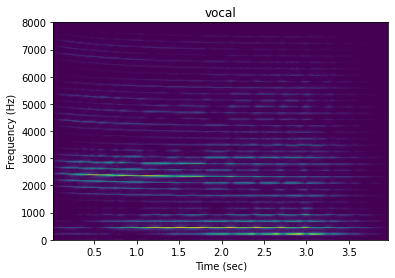

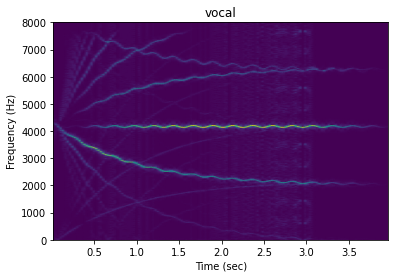

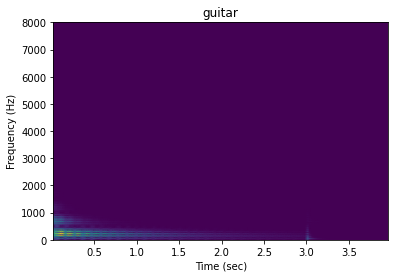

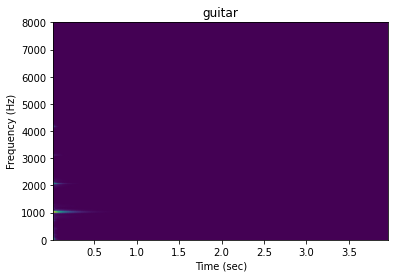

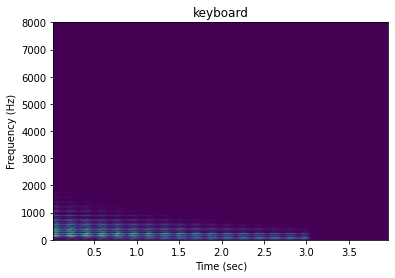

In [56]:
def clean_samples(samples):
    return samples.reshape((samples.shape[0], samples.shape[1])).astype('float32')


def fft(sample, sample_rate, window_size=512):
    """Create the Spectrogram.
    
    This returns an three arrays F (frequency), T (time), and S (spectrogram).
    The entry S[f,t] is the magnitude of frequency F[f] (in Hz) at time T[t] (in seconds).
    """
    f, t, s = signal.spectrogram(sample, fs=sample_rate, nperseg=window_size, mode='magnitude')
    return f, t, s


def visualize(f, t, s, instrument):
    plt.pcolormesh(t, f, s, shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (sec)')
    plt.title(instrument)
    plt.show()

def fft_visualize(sample, label, sample_rate, window_size=512):
    visualize(*fft(sample, sample_rate, window_size=window_size), instruments[label])
    
samples = clean_samples(audio)

number_to_show = 5

for i in range(number_to_show):
    fft_visualize(samples[i], labels[i], sample_rate)
    show_audio = display.Audio(samples[i], rate=sample_rate)
    display.DisplayHandle().display(show_audio)